<a href="https://colab.research.google.com/github/annefrancine/DataScience_Estiam/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/beatboxerish/Breast_Cancer/master/data.csv')

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Exploring the data

In [4]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
del data['Unnamed: 32']


Transformons également notre variable de réponse en une variable de réponse numérique

In [8]:
data['y']= data['diagnosis'].apply(lambda x : 1 if x =='M' else 0)

Vérifions maintenant combien de cas de chaque type ('Malignant' et 'Bénigne') nous avons

In [9]:
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

https://datascientest.com/comment-gerer-les-problemes-de-classification-desequilibree-partie-ii

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


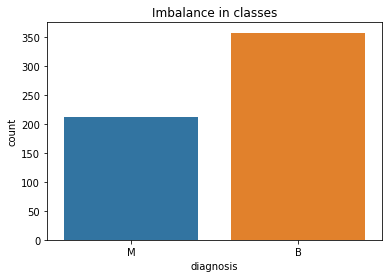

In [11]:
sns.countplot(data.diagnosis)
plt.title('Imbalance in classes');

Nous voyons que les cas « bénins » sont beaucoup plus nombreux que les cas « malignes ».

 ratio of 'Malignant'  : 212/(212 + 357) = 0.37 appx

The ratio of 'Benign'  : 357/(212+357) = 0.627 appx

En raison de ce déséquilibre, nous ne devrions pas utiliser la "accuracy" comme mesure, mais peut-être que le " f1 score" ou une variante du "beta score" serait plus précis.

**N'oubliez pas** : la corrélation n'implique pas la causalité, nous ne pouvons donc pas simplement supposer que les caractéristiques avec une forte corrélation provoquent des changements dans la variable de réponse.

In [12]:
# Checking correlation of features with response variable
print('Features with the max correlation with y :')
print(data.corr()['y'][:-1].sort_values(ascending = False)[:10]) # top 10 features with highest correlations
print('\n')
# Features with lowest correlation (These are not ordered though as mod of negative values hasn't been taken. We must take the mod to measure strength of the neatively correlated features)
print('Features with the least correlation with y :')
print(data.corr()['y'][:-1].sort_values()[:10])

Features with the max correlation with y :
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: y, dtype: float64


Features with the least correlation with y :
smoothness_se             -0.067016
fractal_dimension_mean    -0.012838
texture_se                -0.008303
symmetry_se               -0.006522
id                         0.039769
fractal_dimension_se       0.077972
concavity_se               0.253730
compactness_se             0.292999
fractal_dimension_worst    0.323872
symmetry_mean              0.330499
Name: y, dtype: float64


Ci-dessous, nous vérifions les différences dans les moyennes entre toutes les caractéristiques par rapport au groupe dans lequel les cas appartiennent : « Bénigne » et « Malignant »

In [13]:
data.groupby('diagnosis').mean().iloc[:,1:]

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,y
diagnosis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,0.284082,1.220380,2.000321,21.135148,0.007196,0.021438,0.025997,0.009858,0.020584,0.003636,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442,0.0
M,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,0.609083,1.210915,4.323929,72.672406,0.006780,0.032281,0.041824,0.015060,0.020472,0.004062,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0.5, 1.0, 'Diagnosis VS Mean of symmetry_worst')

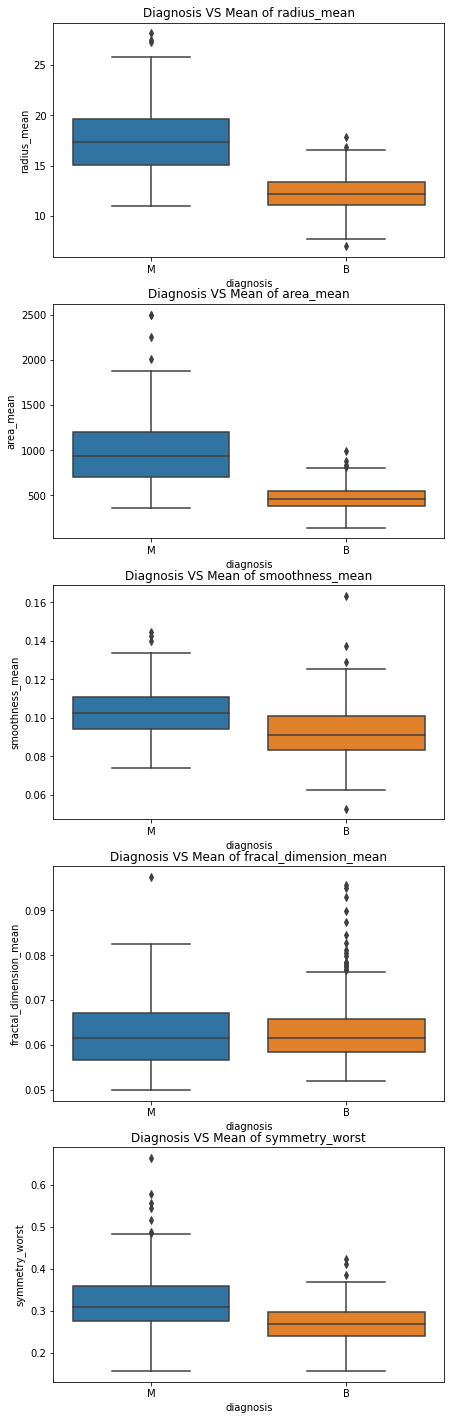

In [14]:
fig,ax = plt.subplots(5,1,figsize = (7,25))
sns.boxplot('diagnosis','radius_mean',data = data,ax=ax[0])
ax[0].set_title('Diagnosis VS Mean of radius_mean')
sns.boxplot('diagnosis','area_mean',data = data,ax=ax[1])
ax[1].set_title('Diagnosis VS Mean of area_mean')
sns.boxplot('diagnosis','smoothness_mean',data = data,ax=ax[2])
ax[2].set_title('Diagnosis VS Mean of smoothness_mean')
sns.boxplot('diagnosis','fractal_dimension_mean',data = data,ax=ax[3])
ax[3].set_title('Diagnosis VS Mean of fracal_dimension_mean')
sns.boxplot('diagnosis','symmetry_worst',data = data,ax=ax[4])
ax[4].set_title('Diagnosis VS Mean of symmetry_worst')

Maintenant, nous vérifions la forme de distribution des entités pour vérifier l'asymétrie.

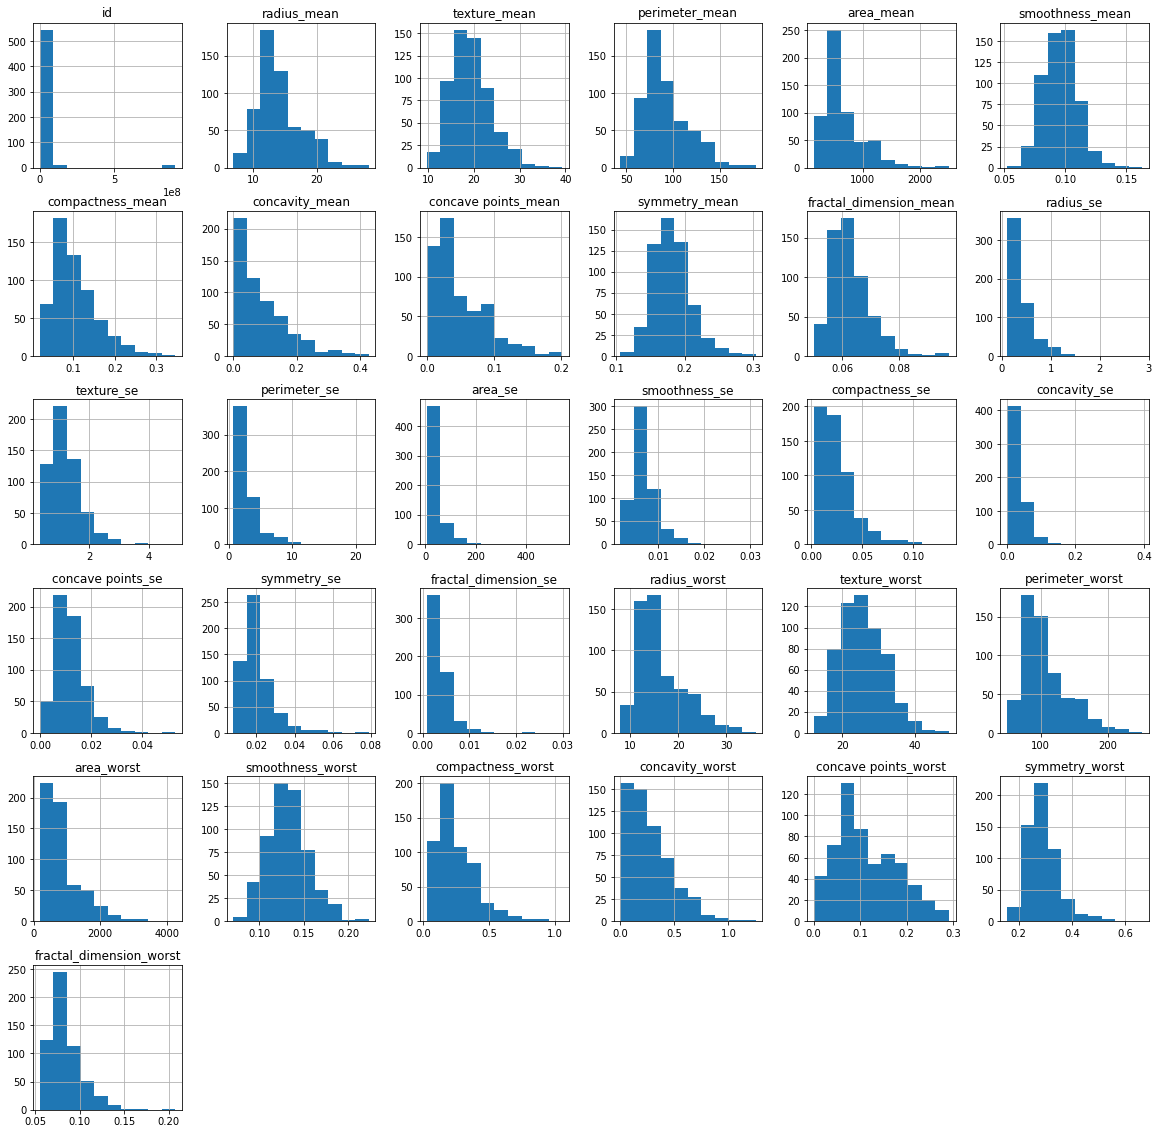

In [15]:
data.iloc[:,:-1].hist(figsize= (20,20));

Vérification de la force et de la direction de l'asymétrie

In [16]:
skew_before_log = data.loc[:,'radius_mean':'fractal_dimension_worst'].skew()
print(skew_before_log)

radius_mean                0.942380
texture_mean               0.650450
perimeter_mean             0.990650
area_mean                  1.645732
smoothness_mean            0.456324
compactness_mean           1.190123
concavity_mean             1.401180
concave points_mean        1.171180
symmetry_mean              0.725609
fractal_dimension_mean     1.304489
radius_se                  3.088612
texture_se                 1.646444
perimeter_se               3.443615
area_se                    5.447186
smoothness_se              2.314450
compactness_se             1.902221
concavity_se               5.110463
concave points_se          1.444678
symmetry_se                2.195133
fractal_dimension_se       3.923969
radius_worst               1.103115
texture_worst              0.498321
perimeter_worst            1.128164
area_worst                 1.859373
smoothness_worst           0.415426
compactness_worst          1.473555
concavity_worst            1.150237
concave points_worst       0

Comme toutes les distributions sont asymétriques vers la droite, nous allons appliquer une transformation logarithmique pour rendre les distributions plus normales et tirer les queues droites vers le centre

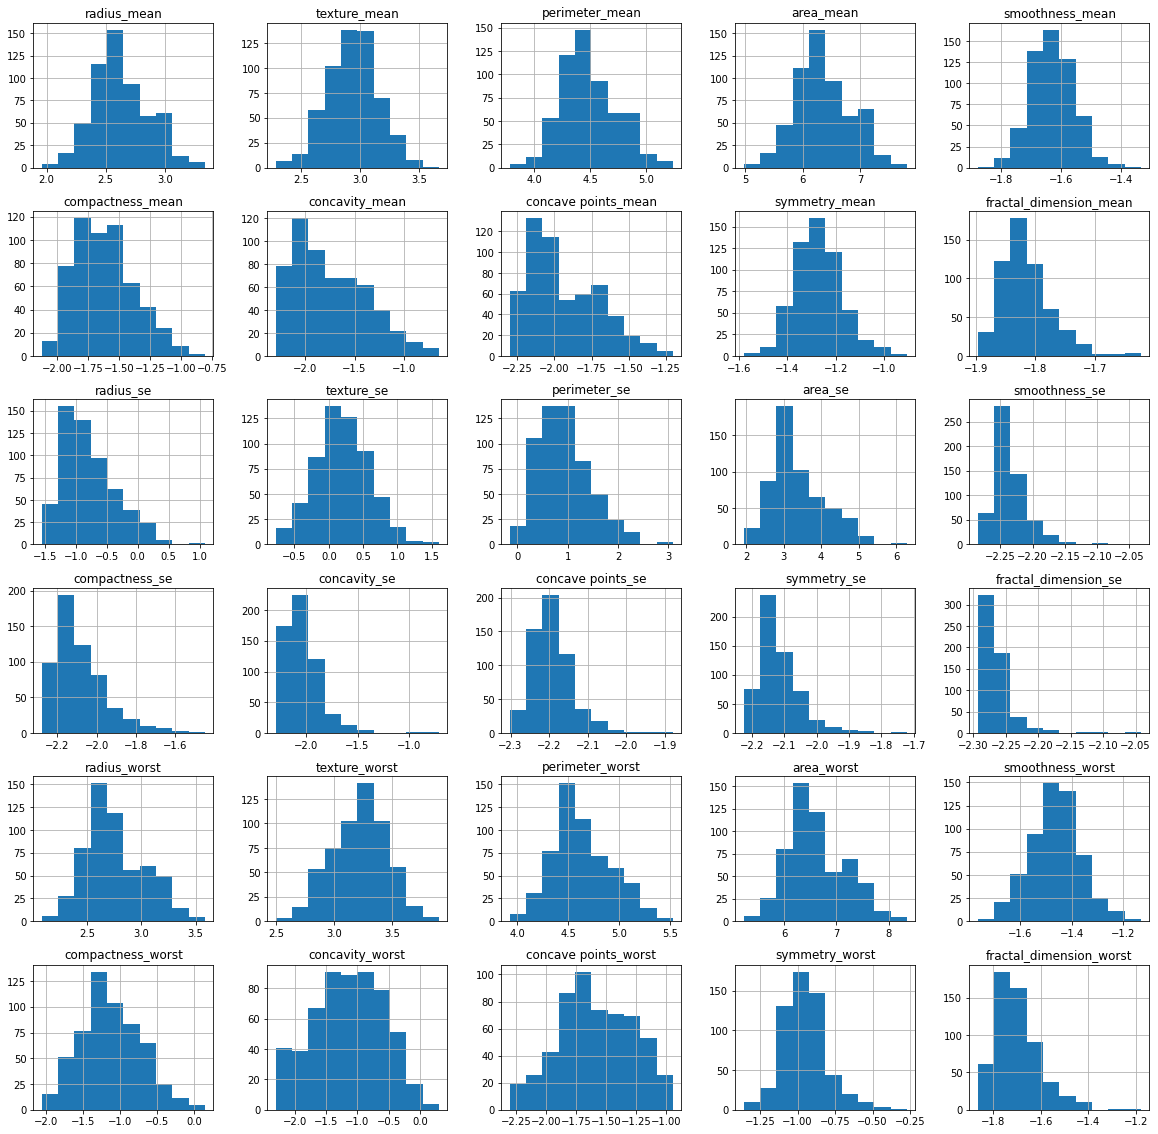

In [17]:
# Make X and y to make it easy to put into train and test categories later
y = data.loc[:,'y']
X = data.iloc[:,2:-1]
# log transform ( We add the '0.1' to x in log to avoid getting : log(0) )
X_log = X.apply(lambda x: np.log(x + 0.1))

# To check how the feature distributions look after log transform
X_log.hist(figsize = (20,20));

In [18]:
skew_after_log = X_log.skew()
print('Amount of skewness reduced :')
print('\n')
print(skew_before_log - skew_after_log)

Amount of skewness reduced :


radius_mean                0.631814
texture_mean               0.660888
perimeter_mean             0.668480
area_mean                  1.360537
smoothness_mean            0.262002
compactness_mean           0.644533
concavity_mean             0.807438
concave points_mean        0.492599
symmetry_mean              0.366948
fractal_dimension_mean     0.194511
radius_se                  2.232933
texture_se                 1.508181
perimeter_se               2.753220
area_se                    4.644365
smoothness_se              0.260092
compactness_se             0.537293
concavity_se               3.184539
concave points_se          0.352275
symmetry_se                0.415144
fractal_dimension_se       0.422709
radius_worst               0.629033
texture_worst              0.621036
perimeter_worst            0.670878
area_worst                 1.403289
smoothness_worst           0.318504
compactness_worst          1.175763
concavity_worst            1.2581

Enfin, nous allons enfin mettre à l'échelle l'ensemble de données. Nous pouvons utiliser soit le MinMaxScaler qui apporte toutes les valeurs entre (0,1) ou le StandardScaler qui modifie les valeurs en faisant la moyenne 0 et l'écart type 1.


In [19]:
# Scale the entire X ds
# This step also brings back all the features within the (0,1) range removing any negative values that were created due to taking log
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_log)

Nos données sont maintenant prêtes pour l'application d'algorithmes d'apprentissage automatique.

**ML**

In [20]:
# Import Preprocessing, metrics and model optimization algos
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
# Dividing X and y into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,random_state = 0)

In [22]:
# Initializing Different Classifiers
clf_dt = DecisionTreeClassifier()
clf_svc = SVC()
clf_rfc = RandomForestClassifier()
clf_ada = AdaBoostClassifier()
clf_lr = LogisticRegression()

In [23]:

# Making a scoring function to use for CV and GridSearchCV
f_beta_scorer = make_scorer(fbeta_score,beta = 2)


Création d'un pipeline qui imprime le nom du classificateur, le score F2 de validation croisée et le score F2 sur l'ensemble de test

In [24]:
# Making a pipeline that prints classifier name, Cross validation F2 score and F2 score on test set. 
# This function will also return score to help us plot and visualize the scores.
# Also, we will be using F2 score as this problem has unbalanced classes and we need to focus more on recall than precision. An 
# F2 score places more importance on recall value than precision.

def classifier(initialized_clf, X_train, y_train, X_test, y_test):
    
    initialized_clf.fit(X_train,y_train)
    cv_scores = [] 
    
    for i in range(5): # Performing CV 5 times so that we get the means of scores for every iteration for a great estimate. 
        cv_scores.append(cross_val_score(initialized_clf,X_train,y_train,scoring = f_beta_scorer,cv = 5).mean()) 
        
    print(initialized_clf)
    print('\n')
    print('Cross Validation F2 Score is :' , np.mean(cv_scores))
    
    preds = initialized_clf.predict(X_test)
    
    print('F2 score on test set is :', fbeta_score(y_test,preds,2))
    print('\n')
    
    cv_scores_mean_plot = np.mean(cv_scores)
    test_scores_plot = fbeta_score(y_test,preds,2)
    
    return (cv_scores_mean_plot),(test_scores_plot)

# Making a function to plot 2 types of scores: Mean F2 score on 5-fold Cross-Validation and F2 score on Test sets
def plot_classifier(clf_names,clf_cv_score,test_score):
    
    fig, ax = plt.subplots(1,2,figsize = (20,8))
    
    sns.barplot(clf_names,clf_cv_score,ax= ax[0]) 
    ax[0].set_title('F2 CV Scores')
    ax[0].set_yticks(np.linspace(0,1,11))
    ax[0].set_ylim(0,1)
    
    sns.barplot(clf_names,test_score,ax= ax[1])
    ax[1].set_title('F2 test Score')
    ax[1].set_ylim(0,1)
    ax[1].set_yticks(np.linspace(0,1,11))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Cross Validation F2 Score is : 0.8785818776745709
F2 score on test set is : 0.9375000000000001




SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Cross Validation F2 Score is : 0.963023894375838
F2 score on test set is : 0.9774436090225564




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_dept

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


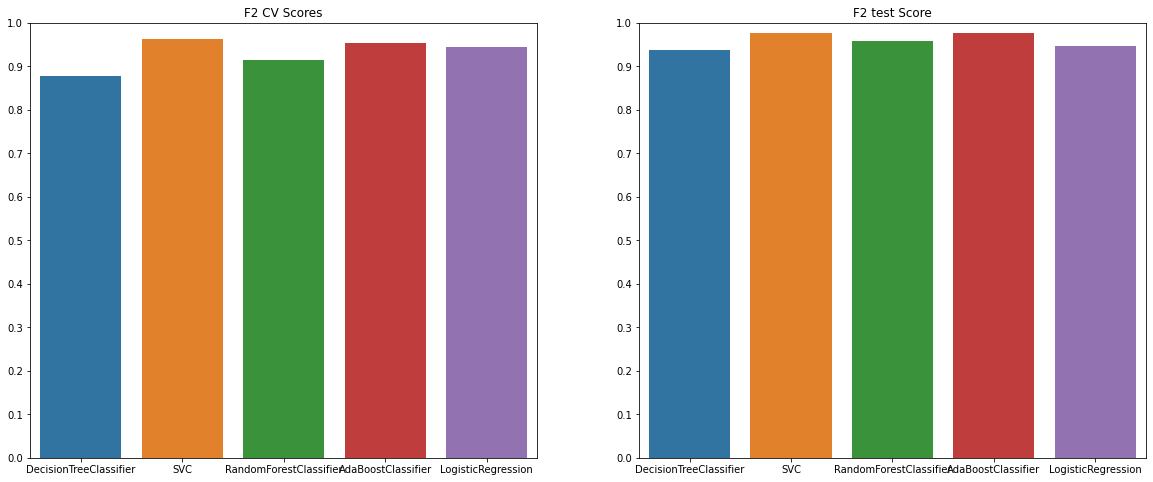

In [25]:
# Create a list with all initialized models
clfs = [clf_dt, clf_svc, clf_rfc, clf_ada, clf_lr]

# Write code to call both plotting and model testing functions
names = []                         # List to store the names of the models for plotting
values_cv_scores = np.zeros(len(clfs))       # array of zeros to store CV scores
values_test_scores = np.zeros(len(clfs))     # array to of zeros to store testing scores

for i in range(len(clfs)):         # This will iterate over the 'clfs' list and run the classifier function on each of the clfs
    values_cv_scores[i],values_test_scores[i] = classifier(clfs[i],X_train,y_train,X_test,y_test)
    print('\n')
    names.append(re.match(r'[A-Za-z]+',str(clfs[i]))[0]) # Extracting the name of the model by extracting all letters before any 
                                                         # special character
    
plot_classifier(names,values_cv_scores,values_test_scores)


Based on the above scores we would like to go ahead with AdaBoostClassifier .The test graphs are just for visualizing and seeing how our algos perform with factory settings.

In [32]:
# Model Optimization
# 1) RandomForestClassifier :: This is done just for fun and experimentation
clf_rfc = RandomForestClassifier(random_state = 0)

params_rfc = {'criterion':['gini','entropy'],'n_estimators':[5,6,7,8,9,10,11,12,15,20],'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,2,3]}
best_rfc = GridSearchCV(clf_rfc,params_rfc,f_beta_scorer,cv = 5)
print('RandomForest')
best_rfc.fit(X_train,y_train)
print('Its best parameters are :',best_rfc.best_params_)
print('F2 score with best parameters :',best_rfc.best_score_)
best_rfc_preds = best_rfc.predict(X_test)
print('F2 score on test set: ',fbeta_score(y_test,best_rfc_preds,2))
print('\n')

# 2) AdaBoostClassifier

clf_dt = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = clf_dt,random_state = 0)

params_ada = {'base_estimator__criterion':['gini','entropy'],'base_estimator__max_depth':[1,2,3,4,5,10,15,20],'n_estimators': [10,20,30,40,100,50]}
best_ada = GridSearchCV(ABC,params_ada,f_beta_scorer,cv= 5)
best_ada.fit(X_train,y_train)
print('AdaBoost')
print('Its best parameters are :',best_ada.best_params_)
print('F2 score with best parameters :',best_ada.best_score_)
best_ada_preds = best_ada.predict(X_test)
print('F2 score on test set :',fbeta_score(y_test,best_ada_preds,2))
print('\n')



RandomForest
Its best parameters are : {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
F2 score with best parameters : 0.9417121626867102
F2 score on test set:  0.966542750929368


AdaBoost
Its best parameters are : {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 4, 'n_estimators': 100}
F2 score with best parameters : 0.9544162716834466
F2 score on test set : 0.9659090909090909




**Studying Feature Importance**

In [29]:

# We will study feature importance for AdaBoostClassifier
feature_names = X.columns.values
feature_values = clf_ada.feature_importances_

In [30]:

# Sorting the features according to their values from max to min
features_imp = sorted(list(zip(feature_values,feature_names)),reverse = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


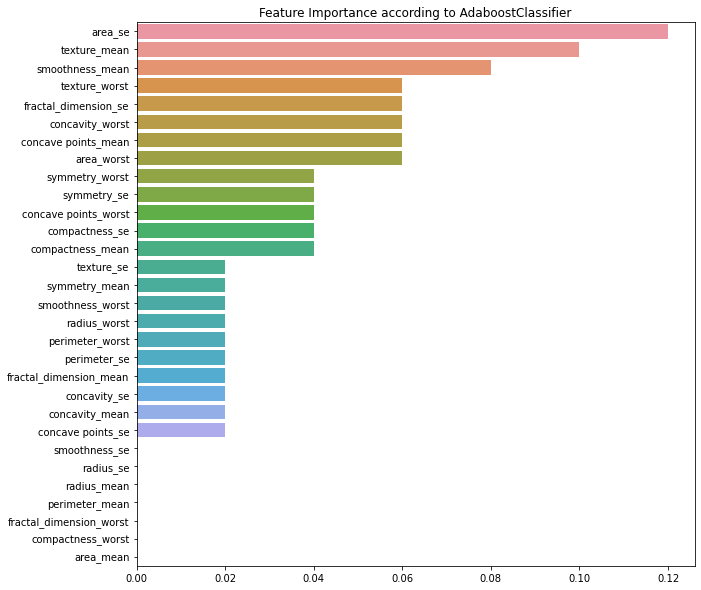

In [31]:

fig,ax = plt.subplots(1,1,figsize = (10,10))
sns.barplot(np.array(features_imp)[:,0].astype('float'), np.array(features_imp)[:,1].astype('str'), orient= 'h')
ax.set_title('Feature Importance according to AdaboostClassifier');

In [33]:
print('We can see the 5 most important features according to the AdaBoostClassifier are : \n')
for i in list(np.array(features_imp[:5])[:,1]):
    print(i)

We can see the 5 most important features according to the AdaBoostClassifier are : 

area_se
texture_mean
smoothness_mean
texture_worst
fractal_dimension_se
